# Image Effects

This notebook contains a couple dozen image transformations.

Some recreating trivial photoshop effects.

Others just having fun with opencv :)


In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import textwrap
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from src.utils import load_rgb, adjust_exponential, plot

## Color dot

- Choose dot size
- Create down sampled copy of original image using dot size
- Create color_dot image matching the original images dimensions
- Use nested for-loop to add circles to color_dot using the down sampled image

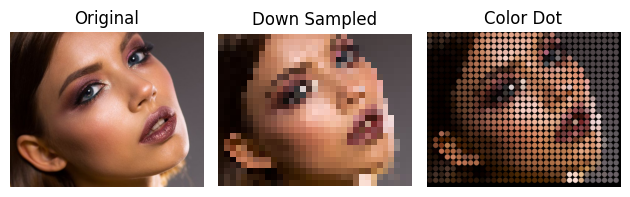

In [2]:
# Load image and create down sampled copy.
rgb = load_rgb("img/face.jpg")
dot_size = 15
small_shape = (rgb.shape[1] // dot_size, rgb.shape[0] // dot_size)
down_sampled = cv2.resize(rgb, small_shape)

# Draw circles.
radius = dot_size // 2
color_dot = np.zeros(rgb.shape, dtype=np.uint8)
for i in range(down_sampled.shape[1]):
    for j in range(down_sampled.shape[0]):
        color = down_sampled[j, i, :].tolist()
        center = (dot_size * i + radius), (dot_size * j + radius)
        cv2.circle(color_dot, center, radius, color, -1)

# Display.
plot(
    1,
    3,
    ("Original", rgb),
    ("Down Sampled", down_sampled),
    ("Color Dot", color_dot),
)


## Halftone

The approach is very similar to color dot.

- Choose halftone circle size and call that block size
- Create down sampled copy of original image using block size
- Compute gray scale of down sampled copy
- Create halftone image matching the original images dimensions
- Use nested for-loop to add circles to halftone using the grayscale pixel intensity

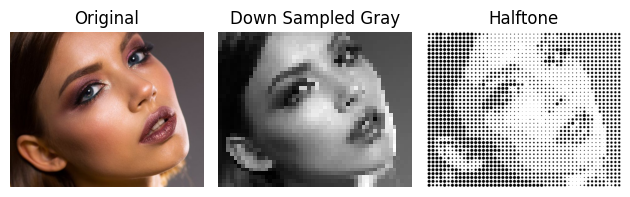

In [3]:
rgb = load_rgb("img/face.jpg")
block_size = 10
small_shape = (rgb.shape[1] // block_size, rgb.shape[0] // block_size)
down_sampled = cv2.resize(rgb, small_shape)
gray = cv2.cvtColor(down_sampled, cv2.COLOR_RGB2GRAY) / 255
radius = block_size // 2

# Draw circles.
halftone = np.full(rgb.shape[0:2], 255, dtype=np.uint8)
for i in range(gray.shape[1]):
    for j in range(gray.shape[0]):
        value = 1 - gray[j, i]
        center = (block_size * i + radius), (block_size * j + radius)
        cv2.circle(halftone, center, int(value * radius), 0, -1)

# Display.
plot(
    1,
    3,
    ("Original", rgb),
    ("Down Sampled Gray", gray),
    ("Halftone", halftone),
)


## Fit arc to ball trajectory

I couldn't find a good image online showing a real parabolic trajectory of a ball.
This simulated image will do.

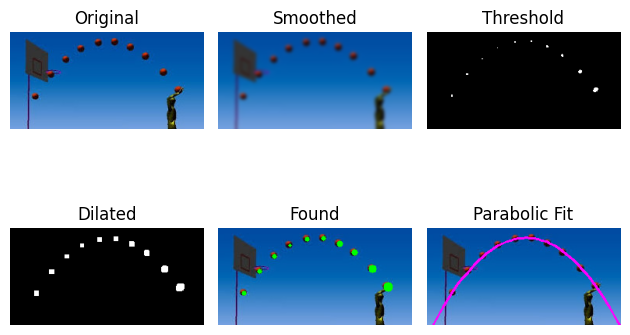

In [4]:
rgb = load_rgb("img/ball_trajectory.jpg")
smoothed_rgb = cv2.GaussianBlur(rgb, (11, 11), 0)
hsv = cv2.cvtColor(smoothed_rgb, cv2.COLOR_RGB2HSV)

# Threshold on ball color.
lower = np.array((0, 60, 60), dtype=np.uint8)
upper = np.array((20, 255, 255), dtype=np.uint8)
threshold = cv2.inRange(hsv, lower, upper)
dilated = cv2.dilate(threshold, np.ones((2, 2), np.uint8), iterations=4)

# Find balls.
points = []
contours, _ = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
found = rgb.copy()
for c in contours:
    (x, y), radius = cv2.minEnclosingCircle(c)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(found, center, radius, (0, 255, 0), -1)
    points.append((int(x), int(y)))

# Find arc of balls.
points = sorted(points, key=lambda x: x[0])
xs, ys = zip(*points)
a, b, c = np.polyfit(xs, ys, 2)
fit_xs = np.linspace(00, 250, 50)
fit_ys = np.array([a * x ** 2 + b * x + c for x in fit_xs])
fit_points = np.array(list(zip(fit_xs, fit_ys)), dtype=np.int64)
arc = cv2.polylines(rgb.copy(), [fit_points], False, (255, 0, 255), 2)

# Display.
plot(
    2,
    3,
    ("Original", rgb),
    ("Smoothed", smoothed_rgb),
    ("Threshold", threshold),
    ("Dilated", dilated),
    ("Found", found),
    ("Parabolic Fit", arc),
)

## Cartoon Portrait

The two main steps to creating a cartoon portrait are color quantizing and making
prominent edges much darker.

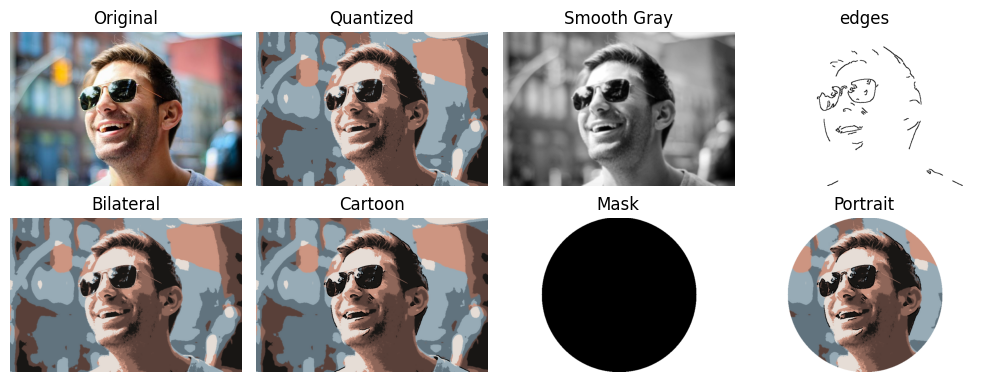

In [5]:
# Load image.
rgb = load_rgb("img/sunglasses.jpg")
h, w = rgb.shape[0:2]

# Reduce colors.
n_colors = 7
linear_rgb = rgb.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_colors, n_init="auto").fit(linear_rgb)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
quantized = centers[labels].reshape(rgb.shape).astype(np.uint8)

# Find edges.
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
smooth_gray = cv2.GaussianBlur(gray, (7, 7), 0)
edges = cv2.Canny(image=smooth_gray, threshold1=160, threshold2=245)
edges = 255 - cv2.dilate(edges, np.ones((2, 2)), iterations=1)

# Work edges into quantized picture.
bilateral = cv2.bilateralFilter(quantized, 9, 75, 75)
cartoon = cv2.bitwise_and(bilateral, bilateral, mask=edges)

# Make it a portrait.
mask = np.full(cartoon.shape[0:2], 1, dtype=np.float64)
mask = cv2.circle(mask, (w // 2, h // 2), h // 2, (0, 0, 0), -1)
alpha = np.dstack([mask] * 3)
portrait = (255 * alpha + (1 - alpha) * cartoon).astype(np.uint8)

# Show original, pixelated, quantized_pixelated.
plot(
    2,
    4,
    ("Original", rgb),
    ("Quantized", quantized),
    ("Smooth Gray", smooth_gray),
    ("edges", edges),
    ("Bilateral", bilateral),
    ("Cartoon", cartoon),
    ("Mask", mask),
    ("Portrait", portrait),
    figsize=(10, 4),
)


## Finding the horizon using a canny edge detector

For this demo, I wanted to explore using a canny edge detector to separate the
ground from the sky. Took a bit of work to find the right settings for the gaussian
filter and canny hysteresis threshold.

The gaussian filter is used to weed out weak edges in order to isolate the horizon.

The [hysteresis threshold](https://theailearner.com/tag/hysteresis-thresholding/)
controls how the edge detector connects weak edges to strong edges.

Look at how `Canny` compares to `Canny Gaussian` to see why it's important to
smooth the minor edges out.

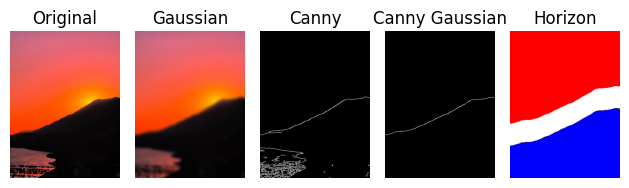

In [6]:
rgb = load_rgb("img/sunset.jpg")
gaussian = cv2.GaussianBlur(rgb, (21, 21), 0)

# Explore canny edge detectors w/ and w/o smoothing.
t1 = 100
t2 = 240
canny_rgb = cv2.Canny(image=rgb, threshold1=t1, threshold2=t2)
canny_gaussian = cv2.Canny(image=gaussian, threshold1=t1, threshold2=t2)

# Create new image.
separated = np.zeros(rgb.shape, dtype=np.uint8)
top_color = (255, 0, 0)
middle_color = (255, 255, 255)
bottom_color = (0, 0, 255)
thickness = 30
for col_index, col in enumerate(canny_gaussian.T):
    sep = int(np.where(col == 255)[0].mean())
    separated[: sep - thickness, col_index, :] = top_color
    separated[sep - thickness : sep + thickness, col_index, :] = middle_color
    separated[sep + thickness + 1 :, col_index, :] = bottom_color

# Display.
plot(
    1,
    5,
    ("Original", rgb),
    ("Gaussian", gaussian),
    ("Canny", canny_rgb),
    ("Canny Gaussian", canny_gaussian),
    ("Horizon", separated),
)


## Median vs Gaussian blurs on noise reduction

Both median and gaussian blur operations smooth out images but have different
effects. Median blurring works by looking at every cell and taking the median of
it and all neighboring cells. Gaussian blurring works by looking at every cell and
averaging it with its neighboring cells.

One benefit of median blurring is its good at getting rid of noise instead of
averaging it in.

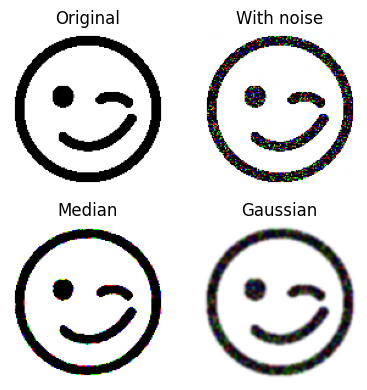

In [7]:
rgb = load_rgb("img/wink.png")
noise = np.random.choice([0, 255], size=rgb.shape, p=[0.9, 0.1])
noisy_rgb = (noise + rgb).astype(np.uint8)

plot(
    2,
    2,
    ("Original", rgb),
    ("With noise", noisy_rgb),
    ("Median", cv2.medianBlur(noisy_rgb, 5)),
    ("Gaussian", cv2.GaussianBlur(noisy_rgb, (5, 5), 0)),
    figsize=(4, 4),
)


## Find tennis ball


To find the tennis ball:

- Look for it's approximate colors
- Try to filter out unwanted colors
- Find the contour around the blobs found in the mask
- Find the minimum circle around the biggest blob and consider it the ball

Note: the values for the threshold we're hand tuned.


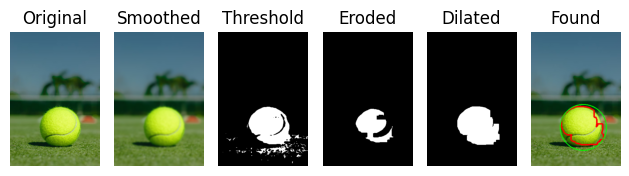

In [8]:
rgb = load_rgb("img/tennis_ball.jpg")
smoothed_rgb = cv2.GaussianBlur(rgb, (11, 11), 0)
hsv = cv2.cvtColor(smoothed_rgb, cv2.COLOR_RGB2HSV)

# Find pixels likely belonging to tennis ball.
lower = np.array((34, 152, 132), dtype=np.uint8)
upper = np.array((44, 255, 255), dtype=np.uint8)
threshold = cv2.inRange(hsv, lower, upper)
eroded = cv2.erode(threshold, np.ones((5, 5), np.uint8), iterations=3)
dilated = cv2.dilate(eroded, np.ones((5, 5), np.uint8), iterations=4)

# Find tennis ball from probable tennis ball pixels.
contours, _ = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
rgb_copy = rgb.copy()
cv2.drawContours(rgb_copy, contours, -1, 255, 3)
(x, y), radius = cv2.minEnclosingCircle(contours[0])
center = (int(x), int(y))
radius = int(radius)
cv2.circle(rgb_copy, center, radius, (0, 255, 0), 2)

# Display.
plot(
    1,
    6,
    ("Original", rgb),
    ("Smoothed", smoothed_rgb),
    ("Threshold", threshold),
    ("Eroded", eroded),
    ("Dilated", dilated),
    ("Found", rgb_copy),
)


## Grayscale

One might think grayscale is as easy as averaging the rgb channels but our eyes
perceive things differently. A better way to grayscale is to use non-linear set
of weights when combining the rgb channels.

More here: https://en.wikipedia.org/wiki/Grayscale

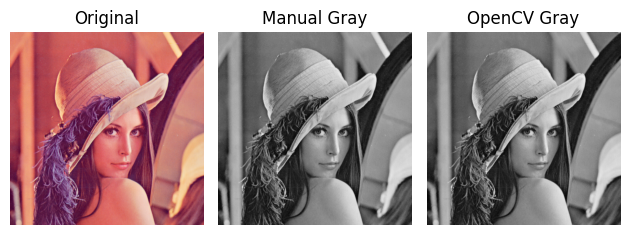

In [9]:
rgb = load_rgb("img/lenna.png")
gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
open_cv_gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plot(1, 3, ("Original", rgb), ("Manual Gray", gray), ("OpenCV Gray", open_cv_gray))


## Hue shifting

Load image as hsv then shift all colors using a simple offset.

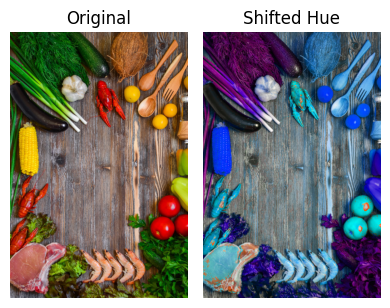

In [10]:
# Load colorful image.
rgb = load_rgb("img/food.jpg")
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

# Created shifted image.
hue = hsv[..., 0]
shift = 90
shifted_hue = (hue + shift) % 180
hsv[:, :, 0] = shifted_hue
shifted_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Plot comparison.
plot(1, 2, ("Original", rgb), ("Shifted Hue", shifted_rgb), figsize=(4, 4))


## Modeling macos dynamic backgrounds

Use [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction) to
emulate macos dynamic backgrounds.
Works non-linearly scaling each channel in rgb space.

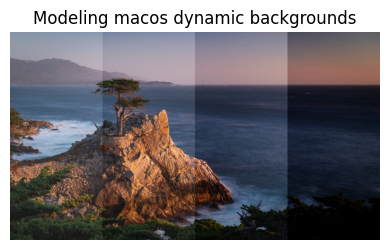

In [11]:
rgb = load_rgb("img/beach.jpg")
gammas = [1.3, 1, 0.7, 0.4]

divides = np.linspace(0, rgb.shape[1], 5).astype(int)
for start, stop, gamma in zip(divides, divides[1:], gammas):
    rgb[:, start:stop, :] = adjust_exponential(rgb[:, start:stop, :], gamma)

plot(1, 1, ("Modeling macos dynamic backgrounds", rgb), figsize=(4, 4))


## Shifting saturation

Same concept as previous demo but adjusting saturation in hsv space instead
of each channel in rgb space.

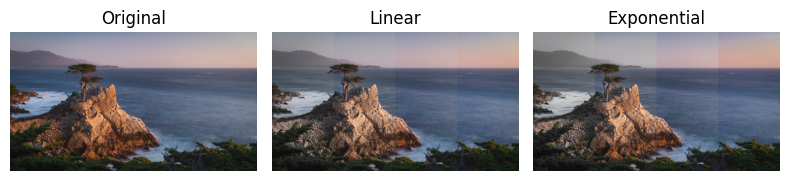

In [12]:
rgb = load_rgb("img/beach.jpg")
hsv_exp = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
hsv_lin = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

saturations = [0.4, 0.7, 1, 1.3]
divides = np.linspace(0, hsv_exp.shape[1], len(saturations) + 1).astype(int)

for start, stop, saturation in zip(divides, divides[1:], saturations):
    hsv_lin[:, start:stop, 1] = hsv_lin[:, start:stop, 1] * saturation
    hsv_exp[:, start:stop, 1] = adjust_exponential(
        hsv_exp[:, start:stop, 1], saturation
    )

# Display.
plot(
    1,
    3,
    ("Original", rgb),
    ("Linear", cv2.cvtColor(hsv_lin, cv2.COLOR_HSV2RGB)),
    ("Exponential", cv2.cvtColor(hsv_exp, cv2.COLOR_HSV2RGB)),
    figsize=(8, 8),
)


## Color quantization + pixelation

Use color quantization + pixelation to attempt to convert new mario photo into
old 1980s version.
Color quantization works by using
[k-keans](https://en.wikipedia.org/wiki/K-means_clustering) clustering.

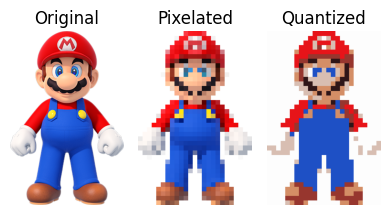

In [13]:
# Load image.
rgb = load_rgb("img/mario.png")

# Create pixelated image.
orig_h, orig_w = rgb.shape[:2]
pixel_w, pixel_h = (25, 38)
down_sampled = cv2.resize(rgb, (pixel_w, pixel_h), interpolation=cv2.INTER_LINEAR)
pixelated = cv2.resize(down_sampled, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

# Quantize the pixelated image.
n_colors = 7
arr = pixelated.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_colors, n_init="auto").fit(arr)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
quantized_pixelated = centers[labels].reshape(pixelated.shape).astype(np.uint8)

# Show original, pixelated, quantized_pixelated.
plot(
    1,
    3,
    ("Original", rgb),
    ("Pixelated", pixelated),
    ("Quantized", quantized_pixelated),
    figsize=(4, 4),
)


## Reflection

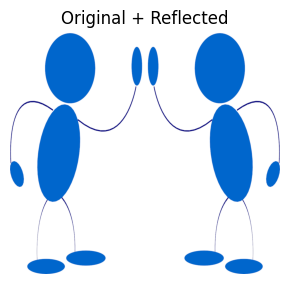

In [14]:
rgb = load_rgb("img/high-five.png")
reflected = cv2.flip(rgb, 1)
joined = np.concatenate((rgb, reflected), axis=1)

plot(1, 1, ("Original + Reflected", joined), figsize=(3, 3))


## Erode and Dilate to fill in holes

This demo will load an image of a dice, find the dice, then fill in the holes
by enlarging and shrinking the mask of the dice.

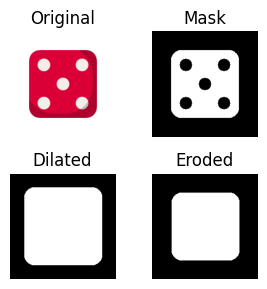

In [15]:
# Load dice and convert to hsv.
rgb = load_rgb("img/dice.png")
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

# Select all the red to find the dice.
lower = np.array([160, 0, 0], dtype=np.uint8)
upper = np.array([185, 255, 255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower, upper)

# Fill in the holes by enlarging then shrinking the mask.
kernel = np.ones((20, 20), np.uint8)
dilated = cv2.dilate(mask, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Display.
plot(
    2,
    2,
    ("Original", rgb),
    ("Mask", mask),
    ("Dilated", dilated),
    ("Eroded", eroded),
    figsize=(3, 3),
)


## Torn paper effect

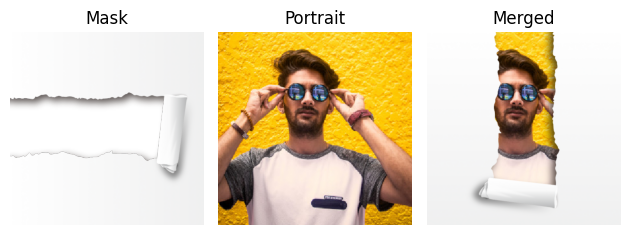

In [16]:
# Separate torn paper mask from its alpha channel.
bgra = cv2.imread("img/torn_paper.png", flags=cv2.IMREAD_UNCHANGED)
rgba = cv2.cvtColor(bgra, cv2.COLOR_BGRA2RGBA)
rgba_rotated = cv2.rotate(rgba, cv2.ROTATE_90_CLOCKWISE)
alpha = rgba_rotated[..., 3] / 255
alpha = np.dstack([alpha] * 3)
torn_paper = rgba_rotated[..., 0:3]

# Load portrait.
portrait = load_rgb("img/fashion_portrait.jpg")
portrait = cv2.resize(portrait, torn_paper.shape[:-1], interpolation=cv2.INTER_NEAREST)

# Merge torn paper with portrait.
merged = (alpha * torn_paper + (1 - alpha) * portrait).astype(np.uint8)

# Display.
plot(1, 3, ("Mask", rgba), ("Portrait", portrait), ("Merged", merged))


## Rotate a caret to create star

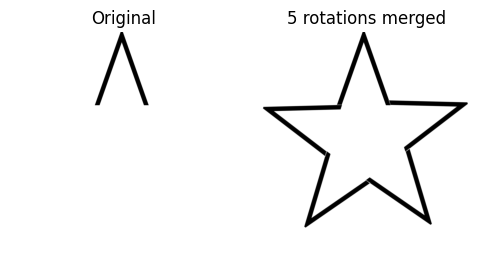

In [17]:
bgra = cv2.imread("img/star_part.png", flags=cv2.IMREAD_UNCHANGED)
rgba = cv2.cvtColor(bgra, cv2.COLOR_BGR2RGBA)

image_center = tuple(np.array(rgba.shape[1::-1]) / 2)

star = rgba.copy()
for i in range(1, 5):
    rot_mat = cv2.getRotationMatrix2D(image_center, 72 * i, 1.0)
    rotated = cv2.warpAffine(rgba, rot_mat, rgba.shape[1::-1], flags=cv2.INTER_LINEAR)
    star += rotated

plot(1, 2, ("Original", rgba), ("5 rotations merged", star), figsize=(5, 5))


## Shifting portions of an image around

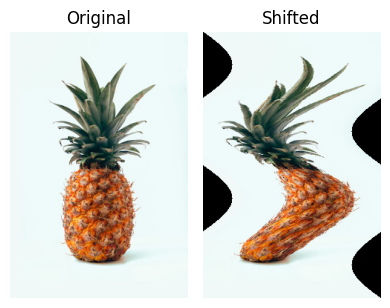

In [18]:
rgb = load_rgb("img/pineapple.jpg")
shifted = np.zeros(rgb.shape, dtype=np.uint8)

shift_scalar = 40
height, width = rgb.shape[:-1]
for i in range(height):
    delta_x = int(shift_scalar * math.sin(math.radians(2 * i)))
    insert_x = max(0, delta_x)
    insert_x2 = min(width, width + delta_x)
    extract_x1 = max(0, -delta_x)
    extract_x2 = min(width, width - delta_x)
    shifted[i, insert_x:insert_x2] = rgb[i, extract_x1:extract_x2]

plot(1, 2, ("Original", rgb), ("Shifted", shifted), figsize=(4, 4))


## Labeled shapes

When using open cv's
[findContours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html),
it will usually produce a lot more edges than you would think. You can approximate
that contour to get back to the expected amount of edges.

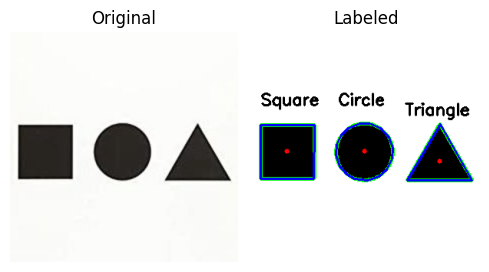

In [19]:
# Load image.
rgb = load_rgb("img/shapes.jpg")
h, w = rgb.shape[0:2]

# Find contours.
_, thresh = cv2.threshold(rgb, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(
    255 - thresh[..., 2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
shapes = thresh.copy()
cv2.drawContours(shapes, contours, -1, (0, 255, 0), 3)

# Create approximate contours.
new_contours = []
for c in contours:
    approx_con = cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True)
    new_contours.append(approx_con)
    approx_size = len(approx_con)
    if approx_size == 3:
        text = "Triangle"
    elif approx_size == 4:
        text = " Square "
    else:
        text = " Circle "
    m = cv2.moments(c)
    cx = int(m["m10"] / m["m00"])
    cy = int(m["m01"] / m["m00"])
    cv2.circle(shapes, (cx, cy), 3, (255, 0, 0), -1)
    cv2.putText(
        shapes, text, (cx - 45, cy - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2
    )

# Draw approximate contours.
cv2.drawContours(shapes, new_contours, -1, (0, 0, 255), 2)

# Show original, pixelated, quantized_pixelated.
plot(
    1,
    2,
    ("Original", rgb),
    ("Labeled", shapes),
    figsize=(5, 3),
)

## Noise gradient


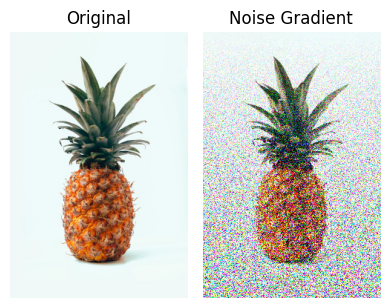

In [20]:
rgb = load_rgb("img/pineapple.jpg")
noise_gradient = np.zeros(rgb.shape, dtype=np.uint8)

noise_scalar = 0.5
height, width = rgb.shape[:-1]
for i in range(height):
    noise = np.random.normal(0, i * noise_scalar, (width, 3))
    noise_gradient[i] = (rgb[i] + noise).clip(0, 255).astype(np.uint8)

plot(1, 2, ("Original", rgb), ("Noise Gradient", noise_gradient), figsize=(4, 4))


## Bloom effect

Add a halo in an image and make it glow

- Create halo in separate mask and blur it
- Blend halo back in

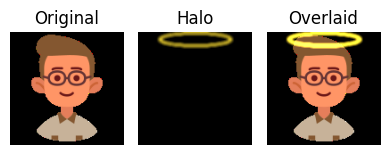

In [21]:
rgb = load_rgb("img/person.png")

# Create halo and blur it.
halo = np.zeros(shape=rgb.shape, dtype=np.uint8)
center = (halo.shape[0] // 2, 9)
halo_size = (40, 7)
color = (255, 223, 50)
halo = cv2.ellipse(halo, center, halo_size, 0, 0, 360, color, 2)
halo = cv2.GaussianBlur(halo, (5, 5), sigmaX=3)

# Blend the layers together.
gain = 2
overlaid_halo = cv2.addWeighted(rgb, 1, halo, gain, 0)

# Display.
plot(
    1, 3, ("Original", rgb), ("Halo", halo), ("Overlaid", overlaid_halo), figsize=(4, 4)
)


## Additive color mixing

Tvs on a per pixel basis are actually made of three separate sub-pixels.
The sub-pixels are comprising of red, green, blue.

I'm curious what recreating this effect looks like if I make an image pixel
the subpixel and consider every three rows a pixel.

I explore 2 different methods here:

1. Make every row either red, green or blue depending on row mod 3x
2. Resize by a factor of 3 then merge

The result is lame lol. I'm essentially just throwing away 2/3 of the data but
it was fun to explore.

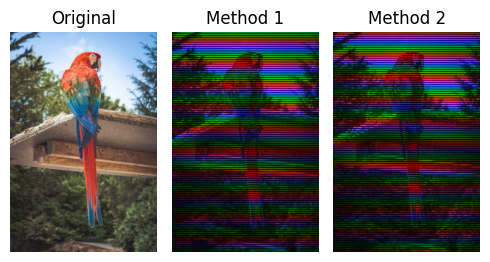

In [22]:
rgb = load_rgb("img/parrot.jpg")
r, g, b = cv2.split(rgb)

# Method 1: zeroing out channels.
r[0::3] = 0
r[1::3] = 0
g[1::3] = 0
g[2::3] = 0
b[2::3] = 0
b[0::3] = 0
method_1 = cv2.merge((r, g, b))

# Method 2: downsample then upsample selectively.
h, w = rgb.shape[:-1]
down_sampled_rgb = cv2.resize(rgb, (w, h // 3))
down_sampled_r, down_sampled_g, down_sampled_b = cv2.split(down_sampled_rgb)
method_2 = np.zeros(rgb.shape, dtype=rgb.dtype)
method_2[0::3, :, 0] = down_sampled_r
method_2[1::3, :, 1] = down_sampled_g
method_2[2::3, :, 2] = down_sampled_b

# Display.
plot(
    1,
    3,
    ("Original", rgb),
    ("Method 1", method_1),
    ("Method 2", method_2),
    figsize=(5, 5),
)


## Cut out text overlay effect

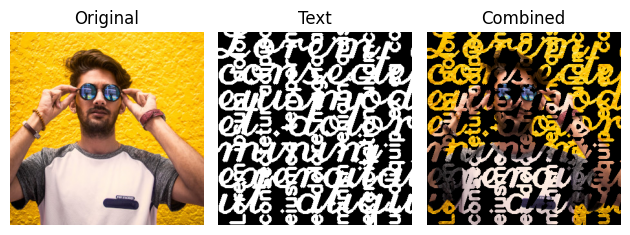

In [23]:
rgb = load_rgb("img/fashion_portrait.jpg")
height, width = rgb.shape[:-1]


def create_text_mask(fontFace, fontScale):
    lorem_ipsum = (
        "Lorem ipsum dolor sit amet, consectetur adipiscing elit, "
        "sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. "
        "Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris "
        "nisi ut aliquip ex ea commodo consequat."
    )
    wrapped_text = textwrap.wrap(lorem_ipsum, width=35)
    text_mask = np.zeros(rgb.shape, np.uint8)
    for i, line in enumerate(wrapped_text, start=1):
        cv2.putText(
            text_mask,
            text=line,
            org=(0, i * 40),
            fontFace=fontFace,
            fontScale=fontScale,
            color=(255, 255, 255),
            thickness=3,
        )
    return text_mask


# Create text masks.
text_mask_1 = create_text_mask(7, 3)
text_mask_2 = create_text_mask(0, 1)

# Rotate second text mask.
image_center = tuple(np.array((height, width)) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, 90, 1.0)
text_mask_2 = cv2.warpAffine(
    text_mask_2, rot_mat, (height, width), flags=cv2.INTER_LINEAR
)

# Combine text masks then use that as a mask for the rgb image.
text_mask = cv2.bitwise_or(text_mask_1, text_mask_2)
combined = cv2.bitwise_and(rgb, text_mask)

# Display.
plot(1, 3, ("Original", rgb), ("Text", text_mask), ("Combined", combined))


## RGB to CMY

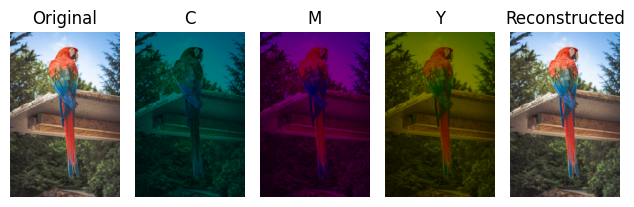

In [24]:
# Load rgb and break apart.
rgb = load_rgb("img/parrot.jpg")
r, g, b = cv2.split(rgb)

# Create cmy.
zeros_chan = np.zeros(rgb.shape[:-1], dtype=np.uint8)
c = np.dstack((zeros_chan, g // 2, b // 2))  # c = g/2 + b/2.
m = np.dstack((r // 2, zeros_chan, b // 2))  # m = r/2 + b/2.
y = np.dstack((r // 2, g // 2, zeros_chan))  # y = r/2 + g/2.

# Display.
plot(
    1,
    5,
    ("Original", rgb),
    ("C", c),
    ("M", m),
    ("Y", y),
    ("Reconstructed", c + m + y),
)


## Concentric rings

When working with unsigned int8s, adding 1 to 255 will make 0.
This concept is more broadly called
[integer overflow](https://en.wikipedia.org/wiki/Integer_overflow).

The program below uses that to cheaply create this cool effect.
It simply renders 2 rings to a mask then adds that to the original image.
Any overflows will simply wrap without error.


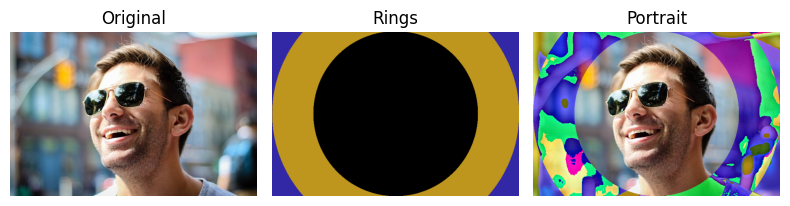

In [25]:
# Load image.
rgb = load_rgb("img/sunglasses.jpg")
h, w = rgb.shape[0:2]

# Make rings.
rings = np.zeros(rgb.shape, dtype=np.uint8)
radii = [w, w // 2, h // 2]
colors = [(50, 40, 165), (190, 150, 30), (0, 0, 0)]
for r, c in zip(radii, colors):
    rings = cv2.circle(rings, (w // 2, h // 2), r, c, -1)

# Show original, pixelated, quantized_pixelated.
plot(
    1,
    3,
    ("Original", rgb),
    ("Rings", rings),
    ("Portrait", rgb + rings),
    figsize=(8, 4),
)
